In [1]:
import numpy as np
import sys 
sys.path.append(r'../Python Script/')

from sympy import symbols, simplify, derive_by_array
from scipy.integrate import solve_ivp
from xLSINDy import *
from sympy.physics.mechanics import *
from sympy import *
import sympy

import torch
import sys 
sys.path.append(r'../../HLsearch/')
import HLsearch as HL
import matplotlib.pyplot as plt

In [2]:
import time

def generate_data(func, time, init_values):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='RK45',rtol=1e-3,atol=1e-6)
    return sol.y.T, np.array([func(0,sol.y.T[i,:]) for i in range(sol.y.T.shape[0])],dtype=np.float64)

g = 9.81
m = 1
l = 1

def spherePend(t,y,Moment=0.0):
    from numpy import sin, cos
    theta, psi, theta_t, psi_t = y
    theta_2t = sin(theta)*cos(theta)*psi_t**2 - (g/l)*sin(theta)
    psi_2t = -2*theta_t*psi_t*cos(theta)/sin(theta)
    return theta_t,psi_t,theta_2t,psi_2t

In [3]:
#Saving Directory
rootdir = "../Spherical Pendulum/"

num_sample = 100
create_data = False
training = False

a = 2
b = 2
noiselevel = a*10**(-b)

In [4]:
if(create_data):
    X, Xdot = [], []
    for i in range(num_sample):
        t = np.arange(0,5,0.01)
        theta = np.random.uniform(np.pi/3, np.pi/2)
        
        y0=np.array([theta, 0, 0, np.pi])
        x,xdot = generate_data(spherePend,t,y0)
        X.append(x)
        Xdot.append(xdot)
    X = np.vstack(X)
    Xdot = np.vstack(Xdot)
    np.save(rootdir + "Data/X.npy", X)
    np.save(rootdir + "Data/Xdot.npy",Xdot)
else:
    X = np.load(rootdir + "Data/X.npy")
    Xdot = np.load(rootdir + "Data/Xdot.npy")

In [5]:
states_dim = 4
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

states are: (x0, x1, x0_t, x1_t)
states derivatives are:  (x0_t, x1_t, x0_tt, x1_tt)


In [6]:
#identifier = "no"
identifier = str(a) + "e-0" + str(b)
if(training==False):
    with open(rootdir + "Data/lagrangian_" + identifier + "_noise.txt") as f:
        L = f.readline()
        print(L)
        expr = L.split(" +")
        device = "cuda:0"
        xi_L = torch.ones(len(expr),device=device)
        mask = torch.ones(len(expr),device=device)

1.0*x1_t**2*sin(x0)**2 + 19.6*cos(x0) + x0_t**2


In [7]:
#obtaining equations of motions
x0 = dynamicsymbols(states[0])
x1 = dynamicsymbols(states[1])
x0_t = dynamicsymbols(states[0],1)
x1_t = dynamicsymbols(states[1],1)
L = eval(str(L))
LM = LagrangesMethod(L, [x0,x1])


LM.form_lagranges_equations()
eom = LM.rhs()


for i in range(len(eom)):
    eom[i] = eom[i].subs(x0_t, states_sym[2])
    eom[i] = eom[i].subs(x1_t, states_sym[3])
    eom[i] = eom[i].subs(x0, states_sym[0])
    eom[i] = eom[i].subs(x1, states_sym[1])

def predictedsphericalpendulum(t,y):
    from numpy import sin, cos
    x0,x1,x0_t,x1_t = y
    x0_tt = eval(str(eom[2]))
    x1_tt = eval(str(eom[3]))
    return x0_t,x1_t,x0_tt,x1_tt



In [8]:
## SINDy-PI ##

'''file name : Spherical Pendulum/Data/SINDy-PI_1e-02_noise.txt'''

def SINDyPI(t,y):
    from numpy import sin, cos
    z1,z2,z3,z4 = y
    dz1=0.9998*z3
    dz2=(3.063*cos(2.0*z1) - 0.8952*z4 - 65.89*cos(z1 - 0.2501) + 5.137*sin(2.0*z1) + 0.4644*z1*z4 + 0.5124*z4*sin(2.0*z1) - 17.51*z1**2 + 62.34)/(1.93*cos(z1 - 1.026) - 1.893)
    dz3=-(1.0*(3.781*z4 + 8.695*cos(2*z1) - 2.964*sin(2*z1) + 17.62*cos(z1) + 53.95*sin(z1) - 2.505*z4*sin(2*z1) - 3.523*z1*z4 + 2.247*z4*sin(z1) - 48.06))/(1.157*cos(z1 - 1.043) - 1.134)
    dz4=-(0.0001*(3.307e+5*cos(2.0*z1 - 1.094) - 3.17e+6*cos(z1 - 0.2796) - 31060.0*z1*z3 + 18280.0*z3*z4 - 7.851e+5*z1**2 + 2.963e+6))/sin(z1)
    return dz1, dz2, dz3, dz4

In [9]:
## Training Results ##
import matplotlib.pyplot as plt


#forward
t = np.arange(0,5,0.01)

idx = 0
y_0 = X[idx,:]

X, Xdot = generate_data(spherePend, t, y_0) 

q_tt_true_wn = (Xdot[:,states_dim//2:].T).copy()
q_t_true_wn = (Xdot[:,:states_dim//2].T).copy()
q_true_wn = (X[:,:states_dim//2].T).copy()

#adding noise
mu, sigma = 0, noiselevel
noise = np.random.normal(mu, sigma, X.shape[0])
for i in range(X.shape[1]):
    X[:,i] = X[:,i]+noise
    Xdot[:,i] = Xdot[:,i]+noise

q_tt_true = Xdot[:,states_dim//2:].T
q_t_true = Xdot[:,:states_dim//2].T
q_true = X[:,:states_dim//2].T

#ours
Xpred, Xdotpred = generate_data(predictedsphericalpendulum, t, y_0) 

q_tt_pred = Xdotpred[:,states_dim//2:].T
q_t_pred = Xdotpred[:,:states_dim//2].T
q_pred = Xpred[:,:states_dim//2].T

#SINDy PI
Xspi, Xdotspi = generate_data(SINDyPI, t, y_0) 

q_tt_spi = Xdotspi[:,states_dim//2:].T
q_t_spi = Xdotspi[:,:states_dim//2].T
q_spi = Xspi[:,:states_dim//2].T

In [10]:
#dummy = np.zeros(q_tt_true.shape)
#dummy[:,:q_spi.shape[1]] = q_spi.copy()
#q_spi = dummy

#dummy = np.zeros(q_tt_true.shape)
#dummy[:,:q_t_spi.shape[1]] = q_t_spi.copy()
#q_t_spi = dummy

#dummy = np.zeros(q_tt_true.shape)
#dummy[:,:q_tt_spi.shape[1]] = q_tt_spi.copy()
#q_tt_spi = dummy

In [11]:
## Test Results ##
ttest = np.arange(5,10,0.01)
y_0 = np.array([q_true_wn[0,-1], q_true_wn[1,-1], q_t_true_wn[0,-1], q_t_true_wn[1,-1]])
Xtest,Xdottest = generate_data(spherePend, ttest, y_0)

y_0 = np.array([q_pred[0,-1], q_pred[1,-1], q_t_pred[0,-1], q_t_pred[1,-1]])
Xtestpred,Xdottestpred = generate_data(predictedsphericalpendulum, ttest, y_0)

y_0 = np.array([q_spi[0,-1], q_spi[1,-1], q_t_spi[0,-1], q_t_spi[1,-1]])
Xtestspi,Xdottestspi = generate_data(SINDyPI, ttest, y_0)

In [12]:
# Concatenante training and test data
t = np.concatenate((t, ttest))
q_tt_true = np.concatenate((q_tt_true, Xdottest[:,states_dim//2:].T), axis=1)
q_t_true = np.concatenate((q_t_true, Xtest[:,states_dim//2:].T), axis=1)
q_true = np.concatenate((q_true,Xtest[:,:states_dim//2].T), axis=1)

q_tt_pred = np.concatenate((q_tt_pred,Xdottestpred[:,states_dim//2:].T), axis=1)
q_t_pred = np.concatenate((q_t_pred, Xtestpred[:,states_dim//2:].T), axis=1)
q_pred = np.concatenate((q_pred,Xtestpred[:,:states_dim//2].T), axis=1)

q_tt_spi = np.concatenate((q_tt_spi,Xdottestspi[:,states_dim//2:].T), axis=1)
q_t_spi = np.concatenate((q_t_spi, Xtestspi[:,states_dim//2:].T), axis=1)
q_spi = np.concatenate((q_spi,Xtestspi[:,:states_dim//2].T), axis=1)

In [13]:
#dummy = np.zeros(q_tt_true.shape)
#dummy[:,:q_spi.shape[1]] = q_spi
#q_spi = dummy

#dummy = np.zeros(q_tt_true.shape)
#dummy[:,:q_t_spi.shape[1]] = q_t_spi
#q_t_spi = dummy

#dummy = np.zeros(q_tt_true.shape)
#dummy[:,:q_tt_spi.shape[1]] = q_tt_spi
#q_tt_spi = dummy

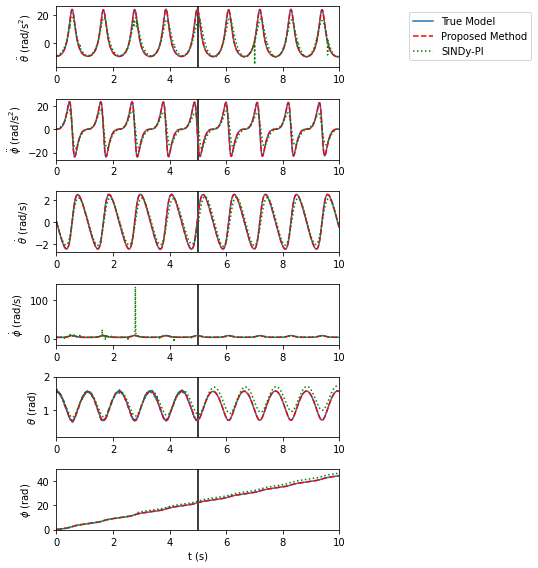

In [14]:
fig, ax = plt.subplots(6,1,figsize=(5,8))

ax[0].plot(t, q_tt_true[0,:], label='True Model')
ax[0].plot(t, q_tt_pred[0,:], 'r--',label='Proposed Method')
ax[0].plot(t, q_tt_spi[0,:], ':g', label='SINDy-PI')
ax[0].set_ylabel('$\ddot{\\theta}$ (rad/s$^2$)')
ax[0].vlines(5,0,1,transform=ax[0].get_xaxis_transform(),colors='k')
ax[0].set_xlim([0,10])

ax[1].plot(t, q_tt_true[1,:], label='True Model')
ax[1].plot(t, q_tt_pred[1,:], 'r--',label='Predicted Model')
ax[1].plot(t, q_tt_spi[1,:], ':g',label='SINDy-PI')
ax[1].set_ylabel('$\ddot{\\phi}$ (rad/s$^2$)')
ax[1].vlines(5,0,1,transform=ax[1].get_xaxis_transform(),colors='k')
ax[1].set_xlim([0,10])

ax[2].plot(t, q_t_true[0,:], label='True Model')
ax[2].plot(t, q_t_pred[0,:], 'r--',label='Predicted Model')
ax[2].plot(t, q_t_spi[0,:], ':g',label='SINDy-PI')
ax[2].set_ylabel('$\dot{\\theta}$ (rad/s)')
ax[2].vlines(5,0,1,transform=ax[2].get_xaxis_transform(),colors='k')
ax[2].set_xlim([0,10])

ax[3].plot(t, q_t_true[1,:], label='True Model')
ax[3].plot(t, q_t_pred[1,:], 'r--',label='Predicted Model')
ax[3].plot(t, q_t_spi[1,:], ':g',label='SINDy-PI')
ax[3].set_ylabel('$\dot{\\phi}$ (rad/s)')
ax[3].vlines(5,0,1,transform=ax[3].get_xaxis_transform(),colors='k')
ax[3].set_xlim([0,10])

ax[4].plot(t, q_true[0,:], label='True Model')
ax[4].plot(t, q_pred[0,:], 'r--',label='Predicted Model')
ax[4].plot(t, q_spi[0,:], ':g',label='SINDy-PI')
ax[4].set_ylabel('$\\theta$ (rad)')
ax[4].vlines(5,0,1,transform=ax[4].get_xaxis_transform(),colors='k')
ax[4].set_ylim([0.2,2])
ax[4].set_xlim([0,10])

ax[5].plot(t, q_true[1,:], label='True Model')
ax[5].plot(t, q_pred[1,:], 'r--',label='Predicted Model')
ax[5].plot(t, q_spi[1,:], ':g',label='SINDy-PI')
ax[5].set_ylabel('$\\phi$ (rad)')
ax[5].set_xlabel('t (s)')
ax[5].vlines(5,0,1,transform=ax[5].get_xaxis_transform(),colors='k')
ax[5].set_ylim([-0.2,50])
ax[5].set_xlim([0,10])

Line, Label = ax[0].get_legend_handles_labels()
fig.legend(Line, Label, loc='upper right', bbox_to_anchor=(1.5, 0.98))

fig.tight_layout()
fig.savefig(rootdir + "Images/training_" + "test "+ "_noise.png", bbox_inches='tight',dpi=400)